### advect_diffuse_3d

Use the down sample version of .nii MRI data, hope for a good interpolation. We mostly use DeepXDE to build research-grade PINN, with several optimization module, which is enough for DCE-MRI task.

1. Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

%matplotlib widget
%load_ext autoreload
%autoreload 2


In [2]:
from dataModule import load_dcemri_data, DCEMRIDataModule
from visualize import visualize_prediction_vs_groundtruth
data,mask,pixdim,x,y,z,t = load_dcemri_data("data/dataset_downsampled.npz")

# Also need to transform anisotropic diffusivity if needed here.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = DCEMRIDataModule(data, mask, t, 
                           pixdim=pixdim, batch_size=20_000, device=device)

(32, 40, 32, 9) (32, 40, 32) [0.5 0.5 0.5]
(32,) (40,) (32,) (9,)


2. Network definition

Here only define a base advect-diffuse PINN that learn the whole, it is reported in [J. D. Toscano et al. 2025](https://doi.org/10.1101/2025.07.30.667741) , that pure AD instead of Darcy's law cannot capture bimodal velocity distribution. 

This version has two variants:
1. simply using FNN to produce velocity field, without any pruning on solution space.
2. physics constrained divergence-free to the 


In [ ]:
class ADPINN(L.LightningModule):
    def __init__(self, c_layers, u_layers, learning_rate=1e-3, incompressible=False):
        
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.incompressible = incompressible

        self.data_loss = nn.MSELoss()

        self.c_net = nn.Sequential()
        self.c_net.add_module("c_input_layer", nn.Linear(c_layers[0], c_layers[1]))
        self.c_net.add_module("c_input_activation", nn.Tanh())
        for i in range(1, len(c_layers) - 2):
            self.c_net.add_module(f"c_hidden_layer_{i}", nn.Linear(c_layers[i], c_layers[i + 1]))
            self.c_net.add_module(f"c_hidden_activation_{i}", nn.Tanh())
        self.c_net.add_module("c_output_layer", nn.Linear(c_layers[-2], c_layers[-1]))
        
        # if incompressible , this v_net will predict vector potential psi instead of velocity directly
        self.v_net_raw = nn.Sequential()
        self.v_net_raw.add_module("v_input_layer", nn.Linear(u_layers[0], u_layers[1]))
        self.v_net_raw.add_module("v_input_activation", nn.Tanh())
        for i in range(1, len(u_layers) - 2):
            self.v_net_raw.add_module(f"v_hidden_layer_{i}", nn.Linear(u_layers[i], u_layers[i+1]))
            self.v_net_raw.add_module(f"v_hidden_activation_{i}", nn.Tanh())
        # The final layer outputs vx, vy, vz
        self.v_net_raw.add_module("v_output_layer", nn.Linear(u_layers[-2], u_layers[-1]))

        # define learnable diffusivity
        self.D = nn.Parameter(torch.tensor(0.01))

        # Initialize weights
        for m in self.c_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
        for m in self.v_net_raw.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
        
        
        # slice domain for visualization
        self.slice_4d = dataset.get_characteristic_geotimedomain(slice_zindex=[data.shape[2]//2], slice_tindex=[data.shape[3]//2])
        self.slice_3d = dataset.get_characteristic_geodomain(slice_zindex=[data.shape[2]//2])
        
        self.slice_gt_c = data[:, :, data.shape[2]//2, data.shape[3]//2]
    
    # WARNING: here x is only spatial coordinates, no time
    def v_model(self, x):
        if self.incompressible:
            psi = self.v_net_raw(x[:, :3]) # steady-assumption
            psi_x, psi_y, psi_z = torch.split(psi, 1, dim=1)
            vx = torch.autograd.grad(psi_z, x[:, 1], grad_outputs=torch.ones_like(psi_z), create_graph=True)[0] - \
                 torch.autograd.grad(psi_y, x[:, 2], grad_outputs=torch.ones_like(psi_y), create_graph=True)[0]
            vy = torch.autograd.grad(psi_x, x[:, 2], grad_outputs=torch.ones_like(psi_x), create_graph=True)[0] - \
                 torch.autograd.grad(psi_z, x[:, 0], grad_outputs=torch.ones_like(psi_z), create_graph=True)[0]
            vz = torch.autograd.grad(psi_y, x[:, 0], grad_outputs=torch.ones_like(psi_y), create_graph=True)[0] - \
                torch.autograd.grad(psi_x, x[:, 1], grad_outputs=torch.ones_like(psi_x), create_graph=True)[0]
        else:
            v = self.v_net_raw(x[:, :3])
            vx, vy, vz = v[:, 0:1], v[:, 1:2], v[:, 2:3]
        return vx, vy, vz

    # WARNING: here x includes time as 4th dimension
    def forward(self, x):
        c = self.c_net(x)
        vx, vy, vz = self.v_model(x)
        return c, vx, vy, vz
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, C_true = batch
        x.requires_grad = True
        C_pred, vx, vy, vz = self.forward(x)
        
        # Compute gradients of density
        grad_C = torch.autograd.grad(C_pred, x, grad_outputs=torch.ones_like(C_pred), create_graph=True)[0]
        C_x, C_y, C_z, C_t = grad_C[:, 0:1], grad_C[:, 1:2], grad_C[:, 2:3], grad_C[:, 3:4]
        
        # Second derivatives
        grad_C_x = torch.autograd.grad(C_x, x, grad_outputs=torch.ones_like(C_x), create_graph=True)[0]
        C_xx = grad_C_x[:, 0:1]

        grad_C_y = torch.autograd.grad(C_y, x, grad_outputs=torch.ones_like(C_y), create_graph=True)[0]
        C_yy = grad_C_y[:, 1:2]

        grad_C_z = torch.autograd.grad(C_z, x, grad_outputs=torch.ones_like(C_z), create_graph=True)[0]
        C_zz = grad_C_z[:, 2:3]

        # Advection-diffusion equation residual
        f = C_t + vx * C_x + vy * C_y + vz * C_z - self.D * (C_xx + C_yy + C_zz)
        
        # Loss: MSE of data and residual
        mse_data = self.data_loss(C_pred, C_true)
        mse_pde = torch.mean(f**2)
        # here follow the paper, setting weight higher for pde
        loss = mse_data + 100 * mse_pde
        
        if batch_idx % 100 == 0:
            self.log('train_loss', loss)
            self.log('data_loss', mse_data)
            self.log('pde_loss', mse_pde)
            self.log('D', self.D)
            # also log velocity magnitude image slices (jointly in one image)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, C_true = batch
        C_pred = self.c_net(x)
        mse_data = self.data_loss(C_pred, C_true)
        
        # also slice c map of mid time + mid z when validation
        if batch_idx == 0:
            self.log('val_data_loss', mse_data)
            if self.current_epoch % 100 == 0:
                with torch.no_grad():
                    vol_disp = self.c_net(self.slice_4d).cpu().numpy().reshape(data.shape[0], data.shape[1])
                    # scale to 0-1 for better visualization
                    vol_disp = (vol_disp - vol_disp.min()) / (vol_disp.max() - vol_disp.min() + 1e-8)
                    # self.logger.experiment.add_image('val_C_slice', vol_disp, self.current_epoch, dataformats='HW')
                    self.logger.experiment.add_image('val_C_compare' ,visualize_prediction_vs_groundtruth(vol_disp, self.slice_gt_c), self.current_epoch, dataformats='WH')
                    
                    vx_img, vy_img, vz_img = self.v_model(self.slice_3d)
                    v_mag_img = torch.sqrt(vx_img**2 + vy_img**2 + vz_img**2).cpu().numpy().reshape(data.shape[0], data.shape[1])
                    self.logger.experiment.add_image('train_v_mag_slice', v_mag_img, self.current_epoch, dataformats='HW')
        return mse_data

3. Training step

TODO: pretrain step. Here directly do joint optimization, no any warm init for velocity or concentration.

In [ ]:
do_training = True

neuron_num = 128
hid_layer_num = 5

# Instantiate the model and trainer or load from checkpoint:
pinn_model = ADPINN(c_layers=[4] + [neuron_num for _ in range(hid_layer_num)] + [1],
    u_layers=[3] + [neuron_num for _ in range(hid_layer_num)] + [3],
    learning_rate=1e-3,
    incompressible=False)

# pinn_model = ADPINN.load_from_checkpoint(
#     "data/adpinn_32_20-52_20250926.pth",
#     c_layers=[4] + [neuron_num for _ in range(hid_layer_num)] + [1],
#     u_layers=[3] + [neuron_num for _ in range(hid_layer_num)] + [3],
#     learning_rate=1e-3,
#     incompressible=False,
# )

logger = TensorBoardLogger("tb_logs", name="naive_ADPINN")


if do_training:
    trainer = Trainer(max_epochs=10_000, log_every_n_steps=3, logger=logger)

    # Train the model

    trainer.fit(pinn_model, dataset)

# After training, visualize the learned velocity field and diffusivity

# Extract learned parameters

D_learned = pinn_model.D.item()

print(f"Learned diffusivity D: {D_learned}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | data_loss    | MSELoss    | 0      | train
1 | c_net        | Sequential | 66.8 K | train
2 | v_net_raw    | Sequential | 66.9 K | train
  | other params | n/a        | 1      | n/a  
----------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.535     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=3). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from datetime import datetime
# save the checkpoint of model for further usage
if do_training:
    trainer.save_checkpoint(f"data/adpinn_{data.shape[0]}_{int(t[0])}-{int(t[-1])}_l{hid_layer_num}_n{neuron_num}_{datetime.now().strftime('%Y%m%d')}.pth")

In [ ]:

# 1. Extract learned velocity field on a grid for visualization
pinn_model.to(device)

# use a grid (from real to characteristic) to extract velocity field
# Create a grid in normalized coordinates
nx, ny, nz = data.shape[0], data.shape[1], data.shape[2]
# to characteristic units first.
grid_tensor = dataset.get_characteristic_geodomain()  # only need spatial part
print(grid_tensor.shape)
# directly using 3D matplotlib to visualize the quiver
with torch.no_grad():
    vx, vy, vz = pinn_model.v_model(grid_tensor)
    
    vx = vx.cpu().numpy().reshape((nx, ny, nz))
    vy = vy.cpu().numpy().reshape((nx, ny, nz))
    vz = vz.cpu().numpy().reshape((nx, ny, nz))
# Scale velocity back to physical units
vx *= dataset.L_star[0] / dataset.T_star
vy *= dataset.L_star[1] / dataset.T_star
vz *= dataset.L_star[2] / dataset.T_star

torch.Size([40960, 3])


In [ ]:
%matplotlib widget

from visualize import draw_3d_quiver, interactive_quiver
# draw_3d_quiver(X, Y, Z, vx, vy, vz, stride=4)
# using mask to filter out the background vectors

# get rid of background vectors by mask
vx = vx * mask
vy = vy * mask
vz = vz * mask
print(pixdim)
_ = interactive_quiver(vx, vy, vz, pixdim)


[0.5 0.5 0.5]


interactive(children=(IntSlider(value=3, description='Stride', max=10, min=1), IntSlider(value=25, description…

torch.Size([368640, 4])
Pred shape: (32, 40, 32, 9) True shape: (32, 40, 32, 9)


Overall MSE: 75.00911712646484


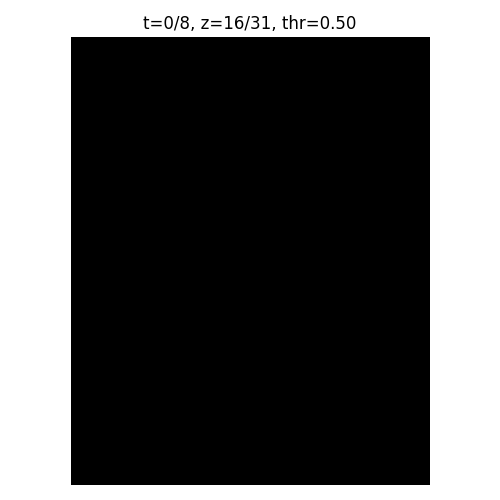

In [ ]:
# 2. Extract all density field with x,y,z,t 4D grid for visualization

grid_tensor_4d = dataset.get_characteristic_geotimedomain()  # include time part
print(grid_tensor_4d.shape)
def predict_concentration_4d(model, pts4, nx, ny, nz, nt, batch_size=200_000):
    out_list = []
    with torch.no_grad():
        for i in range(0, pts4.shape[0], batch_size):
            chunk = pts4[i:i+batch_size]
            pred = model.c_net(chunk)
            out_list.append(pred.cpu())
    C_flat = dataset.points_to_geotimedomain(pts4.cpu().numpy(), torch.cat(out_list, dim=0).numpy())
    # C_flat = torch.cat(out_list, dim=0).numpy().reshape(nx, ny, nz, nt)
    return C_flat

C_pred_4d = predict_concentration_4d(pinn_model, grid_tensor_4d, nx, ny, nz, len(t), batch_size=200_000)

# Back to physical units
C_pred_4d *= dataset.C_star

print("Pred shape:", C_pred_4d.shape, "True shape:", data.shape)  # (nx, ny, nz, nt)

from visualize import draw_nifti_slices_with_time
_ = draw_nifti_slices_with_time(C_pred_4d)
# try calculate loss with true data
from sklearn.metrics import mean_squared_error
mse_overall = mean_squared_error(data.flatten(), C_pred_4d.flatten())

print(f"Overall MSE: {mse_overall}")